# Cityscapes - Resnet50

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
#import adabound # https://github.com/Luolc/AdaBound
from torchsummary import summary
import json
from torchvision.models.segmentation import fcn
#import imageio

from torchvision.transforms.functional import normalize, resize, to_pil_image

from torch.utils.tensorboard import SummaryWriter

# For notificaiton
#import AppKit

torch.cuda.empty_cache()

Device chosen GPU: NVIDIA TITAN RTX


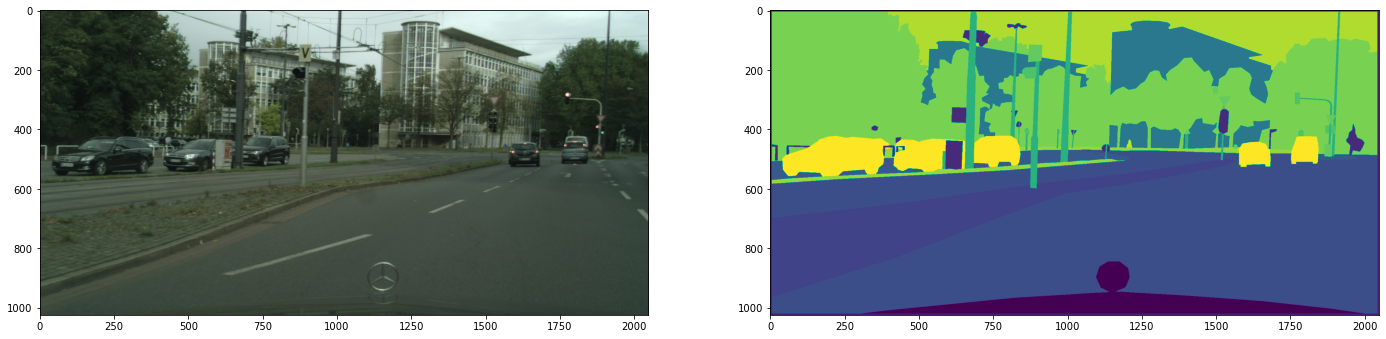

In [2]:
device = torch.device("cuda:0")
print("Device chosen GPU:", torch.cuda.get_device_name(device))
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters
num_classes = 30

# Hyper parameters
num_epochs = 25
#batch_size = 256
batch_size = 32
learning_rate = 0.00001
beta1 = 0.9
beta2 = 0.999
log_directory = f"runs/Cityscapes/resnet101/v0.0.0 Adam lr = {learning_rate}, epochs = {num_epochs}, batchsize ={batch_size}"
writer1  = SummaryWriter(log_directory)
#writer2 = SummaryWriter(log_directory)

# Loading dataset
# Since the dataset is in PIL (Python Imaging Library) form, tranform them into tensors of normalised range [-1, 1]
# transform = transforms.Compose( # this transforms.compose combines multiple tranformations as one
#     [
#         transforms.ToTensor(), 
#         #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#         #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
#     ]
# )

pil_to_tensor = transforms.Compose(
    [ # https://colab.research.google.com/github/CSAILVision/semantic-segmentation-pytorch/blob/master/notebooks/DemoSegmenter.ipynb#scrollTo=-BvRk8ONb00G
        #lambda x: np.array(x),
        transforms.ToTensor(),
    # transforms.Normalize(
    #     mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
    #     std=[0.229, 0.224, 0.225])  # across a large photo dataset.
    ]
)

# The Cityscapes tataset is avaliable in PyTorch
train_dataset = torchvision.datasets.Cityscapes(root='./cityscapesDataset', split='train', mode='fine', target_type='semantic', transform=pil_to_tensor, target_transform=transforms.ToTensor())
test_dataset  = torchvision.datasets.Cityscapes(root='./cityscapesDataset', split='test',  mode='fine', target_type='semantic', transform=pil_to_tensor, target_transform=transforms.ToTensor())
val_dataset   = torchvision.datasets.Cityscapes(root='./cityscapesDataset', split='val',   mode='fine', target_type='semantic', transform=pil_to_tensor, target_transform=transforms.ToTensor())

workers = 5
# Splitting the training and testing datasets into smaller batches
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)#,  num_workers=workers)#, pin_memory=True))
test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)#, num_workers=workers)#, pin_memory=True))

#classes = ('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')

# Checking a data sample 
# example = iter(test_loader)
# images, labels = example.next()

# def imshow(img):
#     img = img / 2 + 0.5  # unnormalize
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.axis("off")
#     plt.show()
# imshow(torchvision.utils.make_grid(images))
fig, ax = plt.subplots(ncols=2, figsize=(24, 16))
ax[0].imshow(train_dataset[7][0].numpy().transpose(1,2,0)) # transpose(1,2,0) changes the order of the dimensions
ax[1].imshow(train_dataset[7][1].numpy().transpose(1,2,0))

In [3]:
# batch_iterator = iter(train_loader)
# current_batch = next(batch_iterator)
# image, target = current_batch
# plt.imshow(image[1].numpy().transpose(1,2,0))

In [4]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading the model
model = torchvision.models.resnet101(pretrained=True).train().to(device)
#summary(model, (3, 2048, 1024))
#model.fc = nn.Linear(512, num_classes).to(device)

#model = nn.DataParallel(model)
#model.to(device)

#num_features = model.features     # Getting the number of features going into the fully connected layer

# Finetuning
for param in model.parameters():    # Freezing/unfreezing the starting layers
    # param.requires_grad = False
    param.requires_grad = False

#model.fc = nn.Linear(len(num_features), 10)  # Redefining the layer with the same input features, but new output features (the amount of classes that we need to classify)
#model.to(device)

#summary(model, (3, 32, 32))

# IOU can be found at https://www.kaggle.com/code/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy/script

criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=[beta1, beta2], eps=1e-08) # Comment this if a model is loaded

n_total_steps = len(train_loader)

print('Train Size   : ', len(train_dataset))
print('Test Size    : ', len(test_dataset))
print('Val Size     : ', len(val_dataset))
summary(model, (3, 2048, 1024))


Train Size   :  2975
Test Size    :  1525
Val Size     :  500
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 64, 1024, 512]           9,408
       BatchNorm2d-2        [-1, 64, 1024, 512]             128
              ReLU-3        [-1, 64, 1024, 512]               0
         MaxPool2d-4         [-1, 64, 512, 256]               0
            Conv2d-5         [-1, 64, 512, 256]           4,096
       BatchNorm2d-6         [-1, 64, 512, 256]             128
              ReLU-7         [-1, 64, 512, 256]               0
            Conv2d-8         [-1, 64, 512, 256]          36,864
       BatchNorm2d-9         [-1, 64, 512, 256]             128
             ReLU-10         [-1, 64, 512, 256]               0
           Conv2d-11        [-1, 256, 512, 256]          16,384
      BatchNorm2d-12        [-1, 256, 512, 256]             512
           Conv2d-13        [-1, 256, 512

In [5]:
# Training

# Tensorboard
#writer1.add_graph(model, images)
#writer1.close()

# Doing the training now

running_loss = 0
running_correct = 0
#running_loss_test = 0

steps_until_print = batch_size
#print(f'One batch has {len(example)/batch_size} images\nPrint every {steps_until_print}')

model.train()
for epoch in range(num_epochs):
    # Check for stop - read file for boolean to stopping safely
    train_json = open("train.json")
    train_dict = json.load(train_json)
    if train_dict["train"] == "False": break
    
    testing_batches = iter(test_loader) # Every epoch tests the whole dataset once

    for i, (images, targets) in enumerate(train_loader):
        
        # images = images_and_targets[i][0].to(device)
        # targets = images_and_targets[i][1].to(device)
        images = images.to(device)
        targets = targets.to(device)

        # Forward pass
        print("Inputs:\n", images.shape)
        outputs = model(images)
        print("Outputs:\n", outputs.shape)
        loss = criterion(outputs, targets)

        # Backward pass
        optimiser.zero_grad()   # Clear old gradient values
        loss.backward()         # Calculate the gradients
        optimiser.step()        # Update the model's weights (these are the model parameters(), different from hyperparameters)


        with torch.no_grad():
            # Add loss to the running loss 
            running_loss = loss.item()
            _, predictions = torch.max(outputs, 1)                  # Evaluate along the 1st dimension

            #running_correct = (predictions == targets).sum().item()  # We can call .item() as it's a tensor with one item

            if (i+1) % 1 == 0: # Maybe replace 1 with steps_until_print
                # Logging the loss
                writer1.add_scalar('Loss/training', running_loss/steps_until_print, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 
                # Adding the accuracy
                #writer1.add_scalar('Accuracy/training', running_correct/batch_size*100, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 

            # If for every 5 batches, test one batch. (test:train data ratio is split 1:5)
            if (i+1) % 5 == 0:  # Logging the testing loss
                test_images, test_targets = testing_batches.next()
                
                test_images = test_images.to(device)
                test_targets = test_targets.to(device)

                test_outputs = model(test_images)

                # _, test_predictions = torch.max(test_outputs, 1)
                # test_running_correct = (test_predictions == test_targets).sum().item()
                # writer1.add_scalar('Accuracy/testing', test_running_correct/batch_size*100, epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step 

                test_loss = criterion(test_outputs, test_targets)
                test_running_loss = test_loss.item()
                writer1.add_scalar('Loss/testing', test_running_loss/len(test_targets), epoch * n_total_steps + i) # label of the scalar, actual loss mean, current global step

    #writer2.add_scalar('Loss/training', running_loss/steps_until_print, epoch * n_total_steps) # label of the scalar, actual loss mean, current global step
    print(f'Epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.5f}')
    #print(f'Finished epoch {epoch+1}/{num_epochs}')

print("Training is done")
#AppKit.NSBeep()

Inputs:
 torch.Size([32, 3, 1024, 2048])
Outputs:
 torch.Size([32, 1000])


RuntimeError: 0D or 1D target tensor expected, multi-target not supported

In [ ]:
# Saving the model
# checkpoint = {
#     "epoch": 90,
#     "model_state": model.state_dict(),
#     "optimiser_state": optimiser.state_dict()
# }
# torch.save(checkpoint, "___checkpoint_densenet201_83p_cifar.pth")
print(len(model.state_dict().keys()))
keys = list(model.state_dict().keys())
print(keys[0:10])
#print(optimiser.state_dict())

1209
['features.conv0.weight', 'features.norm0.weight', 'features.norm0.bias', 'features.norm0.running_mean', 'features.norm0.running_var', 'features.norm0.num_batches_tracked', 'features.denseblock1.denselayer1.norm1.weight', 'features.denseblock1.denselayer1.norm1.bias', 'features.denseblock1.denselayer1.norm1.running_mean', 'features.denseblock1.denselayer1.norm1.running_var']


In [22]:
# Loading the saved model
model = torchvision.models.densenet201(pretrained=False)
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=[beta1, beta2], eps=1e-08)

loaded_checkpoint = torch.load("___checkpoint_densenet201_83p_cifar.pth")
epoch = loaded_checkpoint["epoch"]

# for param in model.parameters():    # Freezing the startign layers
#     # param.requires_grad = False
#     param.requires_grad = False

model.load_state_dict(loaded_checkpoint["model_state"])
optimiser.load_state_dict(loaded_checkpoint["optimiser_state"])

RuntimeError: Error(s) in loading state_dict for DenseNet:
	Unexpected key(s) in state_dict: "fc.weight", "fc.bias". 

## Breaking after epoch POC

In [29]:
# Stop training after epoch POC
import json
import time
keep_training = True
while(keep_training):
    # Opening json 
    train_json = open("train.json")
    train_dict = json.load(train_json)
    # Interpret "train" value as boolean
    keep_training = False if train_dict["train"] == "False" else True
    time.sleep(1)

In [ ]:
# Implementation of previous line
import json

keep_training = True
while(keep_training):
    # Opening json 
    train_json = open("train.json")
    train_dict = json.load(train_json)
    # Interpret "train" value as boolean
    keep_training = False if train_dict["train"] == "False" else True

In [27]:
# Final implementation
import json
import time
keep_training = True
for a in range(0, 120):
    # Opening json 
    train_json = open("train.json")
    train_dict = json.load(train_json)
    if train_dict["train"] == "False": break
    time.sleep(1)